## Work
1. 請嘗試將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間，再進行訓練
2. 請嘗試將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢
3. (optional) 請改用 GPU 進行訓練 (如果你有 GPU 的話)，比較使用 CPU 與 GPU 的訓練速度

In [1]:
# 載入必須使用的 Library
import keras
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train
x_test, y_test = test

num_classes = len(np.unique(y_train))

In [3]:
## 資料前處理
def preproc_x(data):
    return data.astype('float32') / 255.0

def preproc_y(data):
    return  keras.utils.to_categorical(data, num_classes)

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)


In [5]:
## 建立你的神經網路
def build_mlp():
    # build our CNN model, 多加幾層
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    print(model.summary())
    return model
model = build_mlp()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 64)        0         
__________

In [6]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 256

In [7]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [8]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_history = model.fit(x=x_train, y=y_train,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS, shuffle=True,
                                    verbose=1,
                                    validation_data=[x_test, y_test],
                                    callbacks=[es,mc])



Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 6s 112us/step - loss: 1.9661 - acc: 0.3779 - val_loss: 1.6583 - val_acc: 0.4573

Epoch 00001: val_acc improved from -inf to 0.45730, saving model to best_model.h5
Epoch 2/100
50000/50000 [==============================] - 4s 82us/step - loss: 1.3477 - acc: 0.5269 - val_loss: 1.5618 - val_acc: 0.4749

Epoch 00002: val_acc improved from 0.45730 to 0.47490, saving model to best_model.h5
Epoch 3/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.1413 - acc: 0.5990 - val_loss: 1.2368 - val_acc: 0.5901

Epoch 00003: val_acc improved from 0.47490 to 0.59010, saving model to best_model.h5
Epoch 4/100
50000/50000 [==============================] - 4s 74us/step - loss: 1.0273 - acc: 0.6378 - val_loss: 1.1777 - val_acc: 0.5937

Epoch 00004: val_acc improved from 0.59010 to 0.59370, saving model to best_model.h5
Epoch 5/100
50000/50000 [==============================]

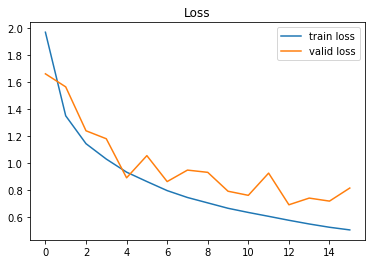

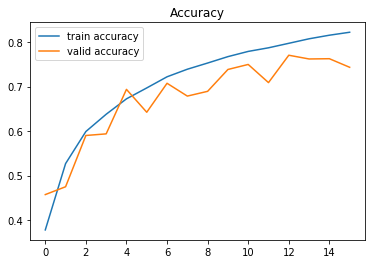

In [10]:
import matplotlib.pyplot as plt


train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()